Could not load feature-engineered data, loading original dataset...
Dataset shape: (30000, 25)

Training set shape: (21000, 23)
Testing set shape: (9000, 23)

Training XGBoost model...

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.66      0.35      0.46      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.68      9000
weighted avg       0.80      0.82      0.79      9000



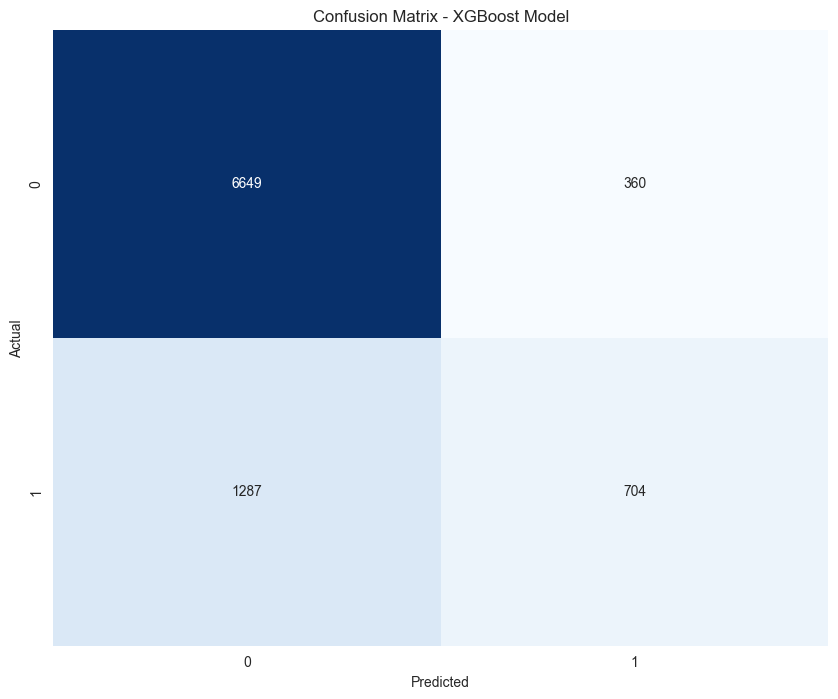

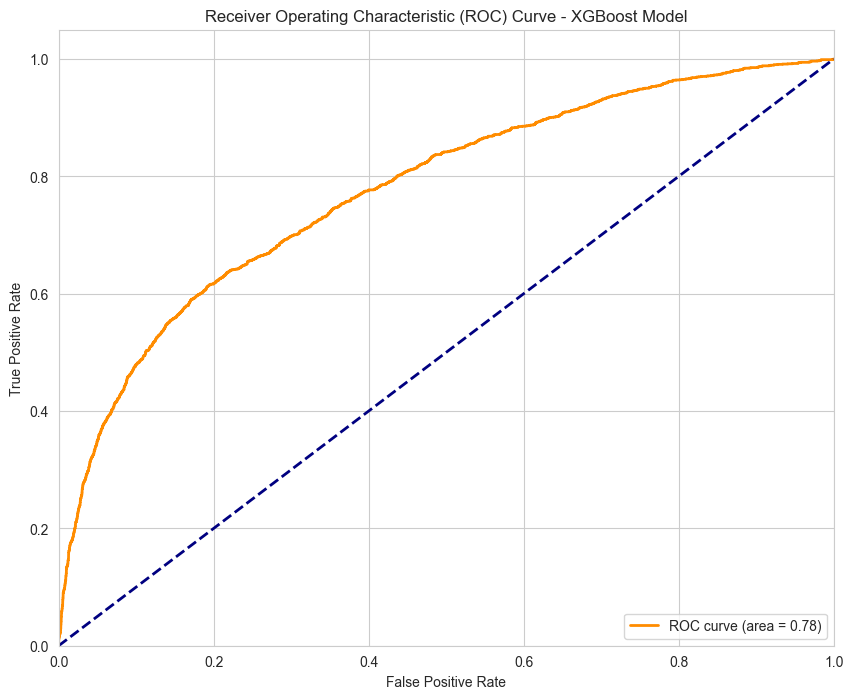

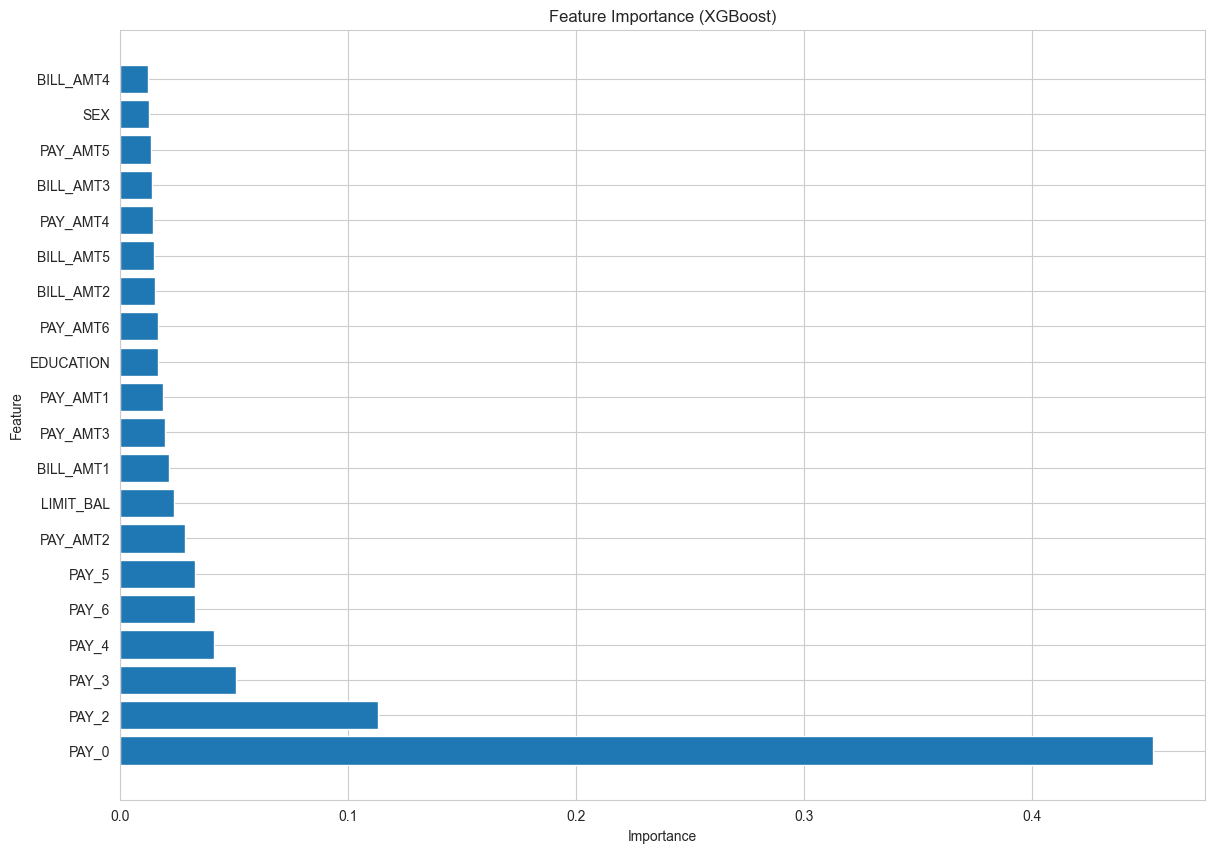

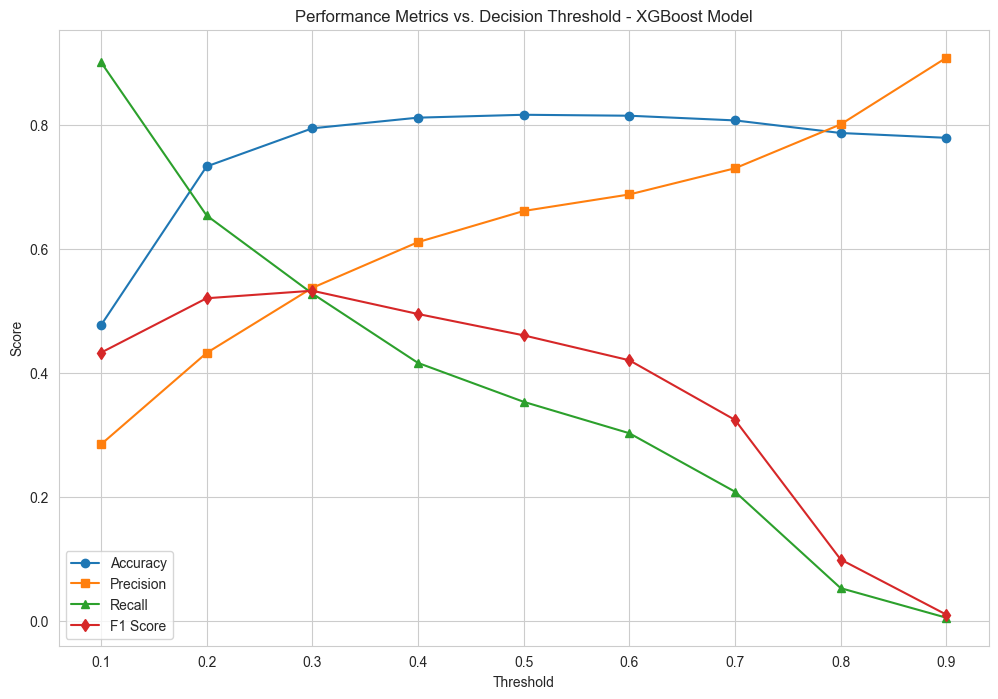

XGBoost modeling complete!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Try to load the feature-engineered dataset
try:
    df = pd.read_csv('./data/credit_card_engineered.csv')
    print("Successfully loaded the feature-engineered dataset")
except:
    print("Could not load feature-engineered data, loading original dataset...")
    df = pd.read_csv('./data/UCI_Credit_Card.csv')
    df = df.rename(columns={"default.payment.next.month": "default"})

print(f"Dataset shape: {df.shape}")

# Separate features and target
X = df.drop(['ID', 'default'], axis=1, errors='ignore')
y = df['default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Try different approaches for XGBoost
print("\nTraining XGBoost model...")

# Approach 1: Using a more basic XGBoost fit method without problematic parameters
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Simple fit without problematic parameters
xgb_model.fit(X_train, y_train)

# Get predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Model')
plt.savefig('./img/xgboost_confusion_matrix.png')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost Model')
plt.legend(loc='lower right')
plt.savefig('./img/xgboost_roc_curve.png')
plt.show()

# Plot feature importance
plt.figure(figsize=(14, 10))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
top_features = feature_importance.head(20)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (XGBoost)')
plt.savefig('./img/xgboost_feature_importance.png')
plt.show()

# Performance threshold analysis
thresholds = np.arange(0.1, 1, 0.1)
accuracy = []
precision_scores = []
recall_scores = []
f1_scores = []

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    accuracy.append(accuracy_score(y_test, y_pred_threshold))
    precision_scores.append(precision_score(y_test, y_pred_threshold))
    recall_scores.append(recall_score(y_test, y_pred_threshold))
    f1_scores.append(f1_score(y_test, y_pred_threshold))

plt.figure(figsize=(12, 8))
plt.plot(thresholds, accuracy, label='Accuracy', marker='o')
plt.plot(thresholds, precision_scores, label='Precision', marker='s')
plt.plot(thresholds, recall_scores, label='Recall', marker='^')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='d')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs. Decision Threshold - XGBoost Model')
plt.legend()
plt.grid(True)
plt.savefig('./img/xgboost_threshold_analysis.png')
plt.show()

print("XGBoost modeling complete!")